# MNIST Handwritten Digits Classification - PyTorch

## Srujan Esanakarra

### November 9, 2021

# Dependencies

In [ ]:
!pip install torch torchvision

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [ ]:
random_seed = 1
# cuDNN is non-deterministic
torch.backends.cudnn.enabled=False
torch.manual_seed(random_seed)

# Dataset

Load MNIST digit dataset from torchvision datasets.

In [ ]:
# Download training data from open datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor()]),
)

# Download test data from open datasets
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor()]),
)

MNIST dataset downloaded from torchvision has 60,000 training examples and 10,000 test examples. 

Split the training set to obtain 55,000 training examples and 5,000 validation examples.

In [ ]:
training_data, validation_data = random_split(training_data, [55000,5000])

Specify hyperparameters.

In [ ]:
NUM_EPOCHS = 10 # number of times the network will see the entire training set
TRAIN_BATCH_SIZE = 100 # number of training points in each iteration
TEST_BATCH_SIZE = 1000 # number of test points in each iteration
LEARNING_RATE = 1e-3 # learning rate for weight and bias updates
MOMENTUM = 0.5 # avoids getting stuck in local minima due to pathological curvature

Create data loaders for the training, validation, and test sets, which wrap iterables over the sets and support automatic batching, sampling, shuffling and multiprocess data loading.

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

## Visualization

Example dataset from the test set for visualization.

In [ ]:
example_data = enumerate(test_dataloader)
batch_index, (example_features, example_targets) = next(example_data)

Size of one test data batch.

In [ ]:
example_features.shape

torch.Size([1000, 1, 28, 28])

Plot a few examples.

<Figure size 432x288 with 0 Axes>

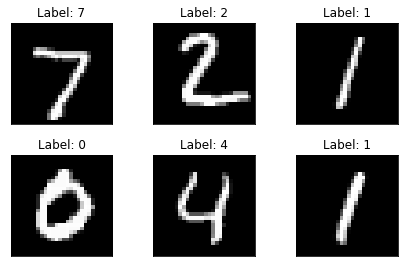

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_features[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.figure()

# Device

Select device for training.

In [ ]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


# Softmax Regression Model

Softmax logistic regression: A linear layer followed by softmax. 
*   NO hidden layers
*   Digit images (28x28 grayscale images) are reshaped into a 784 element vector

Model Class for Logistic Regression

The weights are initialized using Xavier initialization, in which the values are sampled from $\mathcal{N}(0,\text{std}^2)$ where 
\begin{equation}
\text{std} = \text{gain} \times \sqrt(\frac{2}{\text{input_dim} + \text{output_dim}})
\end{equation}
where gain is a scaling factor (default = 1.0)

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    # initialize base class for all neural network modules
    super(LogisticRegression, self).__init__()
    # applies a linear transformation to the input data: y = xA^T+b
    self.linear = nn.Linear(input_dim, output_dim)
    # initialize weights for the layer using zeros since this is just regression
    nn.init.zeros_(self.linear.weight)
    # initialize biases to zeros
    nn.init.zeros_(self.linear.bias)
  
  def forward(self, x):
    # get outputs from linear transformation
    outputs = self.linear(x)
    # return outputs
    return outputs

Instantiate model class

In [ ]:
input_dim = 28*28 # number of input features
output_dim = 10 # number of classes

model = LogisticRegression(input_dim, output_dim).to(device)

Instantiate loss class

In [ ]:
# computes softmax and cross entropy; PyTorch CrossEntropyLoss() applies
# LogSoftmax() and NLLLoss() (negative log likelihood loss), so raw logits
# are passed to the loss function
loss_fn = nn.CrossEntropyLoss()

Instantiate optimizer class

The optimizer is the learning algorithm; we will use Stochastic Gradient Descent

The update equation is as follows
\begin{equation}
  \theta = \theta - \eta \cdot \nabla_\theta
\end{equation}
where $\theta$ represents the parameters, $\eta$ represents the learning rate, and $\nabla_\theta$ represents the parameters' gradients

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=MOMENTUM)

Function to train the model
*   Convert inputs/labels to tensors with gradients
*   Clear gradient buffers
*   Get outputs from linear layer
*   Get softmax cross entropy loss
*   Get gradients w.r.t parameters
*   Update parameters using gradients
*   Repeat for all batches for all epochs



In [ ]:
def train(dataloader, model, loss_fn, optimizer, CNN=False):
  # number of images in training set
  size = len(dataloader.dataset)
  # indicates intention to train; sets behavior for BatchNorm, Dropout, etc. accordingly
  model.train()
  # train model using mini-batches for each iteration
  for batch, (X, y) in enumerate(train_dataloader):
    # load images and labels as Variable
    # for CNN, images should not be collapsed into vectors
    if CNN:
      X = X.requires_grad_() # enables gradient computation for tensor
    else:
      X = X.view(-1, 28*28).requires_grad_() 
    y = y
    # moves tensors to the device being used for training (cpu or gpu)
    X, y = X.to(device), y.to(device)
    # clears gradients w.r.t. parameters
    optimizer.zero_grad()
    # forward propagation to get outputs (logits)
    outputs = model(X)
    # calculates loss (softmax cross entropy loss)
    loss = loss_fn(outputs, y)
    # computes gradients w.r.t. parameters (tensors)
    loss.backward()
    # updates gradients w.r.t. parameters using internally stored grad values
    optimizer.step()

    # print loss after every 100*BATCH_SIZE batches
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Function to check model's performance against the validation set to ensure it is learning and return validation loss

In [ ]:
def validate(dataloader, model, loss_fn, CNN=False):
  # number of images in validation set
  size = len(dataloader.dataset)
  # number of batches in set
  num_batches = len(dataloader)
  # indicates intention to test; sets behavior of BatchNorm, Dropout, etc. accordingly
  model.eval()
  # variables to hold loss and accuracy for each batch
  val_loss, correct = 0, 0
  # disable gradient calculation
  with torch.no_grad():
    # iterates through each batch in the dataloader
    for X, y in dataloader:
      # load images and labels as Variable
      if not CNN:
        X = X.view(-1, 28*28)
      y = y
      # moves tensors to the device being used for execution (cpu or gpu)
      X, y = X.to(device), y.to(device)
      # forward propagation to get outputs (logits)
      raw_outputs = model(X)
      # apply softmax to outputs
      outputs = F.softmax(raw_outputs, dim=-1)
      # validation losses for the batch
      val_loss += loss_fn(outputs, y).item()
      # number of correct predictions for the batch
      correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
    
    # average validation loss for batch
    val_loss /= num_batches
    # accuracy for the batch
    correct /= size
    
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Validation loss: {val_loss:>8f} \n")
  
  return val_loss

Function to calculate accuracy on the test set and return predictions

In [ ]:
def test(dataloader, model, CNN=False):
  # number of images in test set
  size = len(dataloader.dataset)
  # number of batches in set
  num_batches = len(dataloader)
  # indicates intention to test; sets behavior of BatchNorm, Dropout, etc. accordingly
  model.eval()
  # variable to hold predictions for the test set
  predictions = []
  # variable to hold accuracy
  correct = 0
  # disable gradient calculation
  with torch.no_grad():
    # iterates through each batch in the dataloader
    for X, y in dataloader:
      # load images and labels as Variable
      if not CNN:
        X = X.view(-1, 28*28)
      y = y
      # moves tensors to the device being used for execution (cpu or gpu)
      X, y = X.to(device), y.to(device)
      # forward propagation to get outputs (logits)
      raw_outputs = model(X)
      # apply softmax to outputs
      outputs = F.softmax(raw_outputs, dim=-1)
      # get predicted labels from outputs
      predictions.append(outputs.argmax(1))
      # calculate number of correctly predicted labels
      correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
    
    # calculate accuracy on test set
    correct /= size
    
    print(f"Test Accuracy: {(100*correct):>0.1f}% \n")
  
  return predictions

Train the Logistic Regression model

In [ ]:
print(f"Training Logistic Regression Model using Softmax Cross-Entropy Loss\n\n")
# variable to track validation loss
min_val_loss = np.Inf
# train the model for the set number of epochs
for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # determine validation loss for the current epoch
    val_loss = validate(validation_dataloader, model, loss_fn)
    # update minimum validation loss and save the best model
    if val_loss < min_val_loss:
      print('Validation loss decreased ({:.6f} --> {:.6f})\nSaving model ... \n\n'.format(
        min_val_loss,
        val_loss))
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
print("Done!")

Training Logistic Regression Model using Softmax Cross-Entropy Loss


Epoch 1
-------------------------------
loss: 2.302585  [    0/55000]
loss: 0.455566  [10000/55000]
loss: 0.270350  [20000/55000]
loss: 0.238551  [30000/55000]
loss: 0.226443  [40000/55000]
loss: 0.360527  [50000/55000]
Validation Error: 
 Accuracy: 91.2%, Validation loss: 1.592569 

Validation loss decreased (inf --> 1.592569)
Saving model ... 


Epoch 2
-------------------------------
loss: 0.212245  [    0/55000]
loss: 0.399064  [10000/55000]
loss: 0.151578  [20000/55000]
loss: 0.237751  [30000/55000]
loss: 0.340079  [40000/55000]
loss: 0.432907  [50000/55000]
Validation Error: 
 Accuracy: 91.2%, Validation loss: 1.589383 

Validation loss decreased (1.592569 --> 1.589383)
Saving model ... 


Epoch 3
-------------------------------
loss: 0.231997  [    0/55000]
loss: 0.296141  [10000/55000]
loss: 0.235258  [20000/55000]
loss: 0.120359  [30000/55000]
loss: 0.221681  [40000/55000]
loss: 0.657365  [50000/55000]
Valid

Calculate test accuracy for Logistic Regression Model

In [ ]:
print(f"Test Accuracy for Softmax Logistic Regression\n\n")

# calculate test accuracy and obtain label predictions
predictions = test(test_dataloader, model)
# predictions is populated in batches, so we are concatenating
# the results
predictions = torch.stack(predictions)
# flatten stacked results into a 1D array
predictions = predictions.reshape(1, -1).squeeze()

Test Accuracy for Softmax Logistic Regression


Test Accuracy: 92.0% 



Plot of 10 random digits from test set

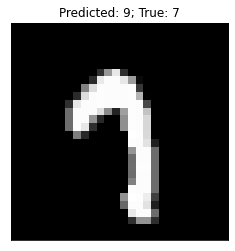

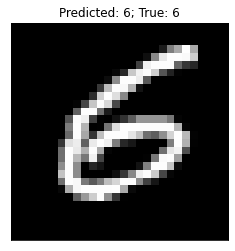

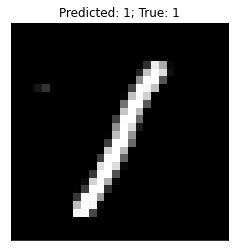

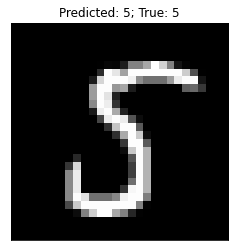

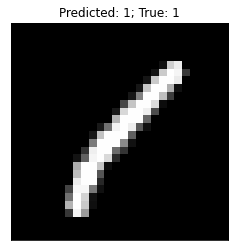

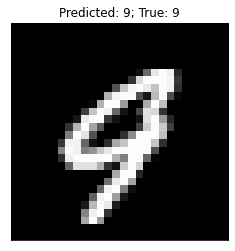

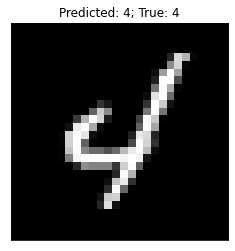

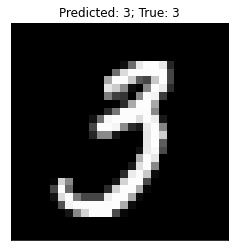

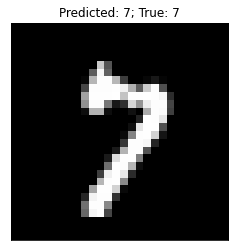

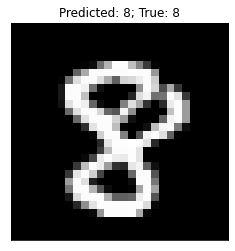

In [ ]:
# get 10 random indices for test data
sample_indices = torch.randint(len(test_data), (10,))
# obtain subset of test data using the generated sample_indices
sample_test_data = Subset(test_data, sample_indices)
# wrap dataloader around sample_test_data
sample_test_dataloader = DataLoader(sample_test_data, batch_size=1, shuffle=False)
# obtain subset of predictions for test data samples
sample_predictions = torch.index_select(predictions, 0, sample_indices)

# enumerate samples for visualization
samples = enumerate(sample_test_dataloader)

# visualize the 10 test data points randomly selected and plot the image with
# the predicted and true labels
for i in range(10):
  batch_idx, (sample_feature, sample_target) = next(samples)
  plt.imshow(sample_feature[0][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {}".format(sample_predictions[i]) + "; True: {}".format(sample_target[0]))
  plt.xticks([])
  plt.yticks([])
  plt.show()

Reload best Logistic Regression model

In [ ]:
# create placeholder for the best model to be loaded
best_model = LogisticRegression(input_dim, output_dim)
# create placeholder for the best optimizer to be loaded
best_optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [ ]:
# reload best model
model_state_dict = torch.load('model.pth')
best_model.load_state_dict(model_state_dict)

# reload best optimizer
optimizer_state_dict = torch.load('optimizer.pth')
best_optimizer.load_state_dict(optimizer_state_dict)

Test accuracy using best Logistic Regression model

In [ ]:
print(f"Test Accuracy for Softmax Logistic Regression using the Best Model\n\n")

# calculate test accuracy using the best model and obtain label predictions
predictions = test(test_dataloader, best_model)
# predictions is populated in batches, so we are concatenating
# the results
predictions = torch.stack(predictions)
# flatten stacked results into a 1D array
predictions = predictions.reshape(1, -1).squeeze()

Test Accuracy for Softmax Logistic Regression using the Best Model


Test Accuracy: 92.2% 



# Multi-layer Perceptron

Specify hyperparameters

In [ ]:
NUM_EPOCHS = 20 # number of times the network will see the entire training set
TRAIN_BATCH_SIZE = 50 # number of training points in each iteration
TEST_BATCH_SIZE = 1000 # number of test points in each iteration
LEARNING_RATE = 1e-4 # learning rate for weight and bias updates

Create data loaders for the training, validation, and test sets, which wrap iterables over the sets and support automatic batching, sampling, shuffling and multiprocess data loading.

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

Softmax Multi-Layer Perceptron: A network with 1 hidden layer followed by softmax. 
*   Digit images (28x28 grayscale images) are reshaped into a 784 element vector
*   Hidden layer has 512 hidden units

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    # initialize base class for all neural network modules
    super(MLP, self).__init__()
    # flattens input
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        # applies a linear transformation to the input data: y = xA^T+b
        # linear layer (input_dim -> hidden_dim)
        nn.Linear(input_dim, hidden_dim),
        # ReLU non-linear activation function; function: max(0,x)
        nn.ReLU(),
        # linear layer (hidden_dim -> output_dim)
        nn.Linear(hidden_dim, output_dim)
    )
    # initialize weights and biases for the layers
    self.layers.apply(self.init_parameters)

  def init_parameters(self, layer):
    if isinstance(layer, nn.Linear):
      # initialize weights for the layers according to a truncated standard normal
      # distribution (mean=0.0, std=0.1); values outside of 2 standard deviations 
      # are resampled until they fall within 2 standard deviations; truncated normal 
      # helps avoid hidden units synchronizing and not learning individually
      nn.init.trunc_normal_(layer.weight, std=0.1)
      # initialize biases for the layers to a constant value of 0.1 to help
      # prevent hidden units from remaining inactive due to ReLU
      nn.init.constant_(layer.bias, 0.1)
  
  def forward(self, x):
    # flatten input
    x = self.flatten(x)
    # get outputs from forward propagation through the network
    outputs = self.layers(x)
    # return outputs
    return outputs

Instantiate MLP class

In [ ]:
input_dim = 28*28 # number of input features
hidden_dim = 512 # number of hidden units in hidden layer
output_dim = 10 # number of classes

model = MLP(input_dim, hidden_dim, output_dim).to(device)

Instantiate loss class

We use cross entropy loss on a softmax distribution on the outputs, just as with the regression model

In [ ]:
# computes softmax and cross entropy; PyTorch CrossEntropyLoss() applies
# LogSoftmax() and NLLLoss() (negative log likelihood loss), so raw logits
# are passed to the loss function
loss_fn = nn.CrossEntropyLoss()

Instantiate optimizer class

We use an AdamOptimizer here

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Train the MLP model

We can use the same train, validate, and test methods from earlier

In [ ]:
print(f"Training MLP Model using Softmax Cross-Entropy Loss\n\n")
# variable to track validation loss
min_val_loss = np.Inf
# train the model for the set number of epochs
for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # determine validation loss for the current epoch
    val_loss = validate(validation_dataloader, model, loss_fn)
    # update minimum validation loss and save the best model
    if val_loss < min_val_loss:
      print('Validation loss decreased ({:.6f} --> {:.6f})\nSaving model ... \n\n'.format(
        min_val_loss,
        val_loss))
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
print("Done!")

Training MLP Model using Softmax Cross-Entropy Loss


Epoch 1
-------------------------------
loss: 3.676155  [    0/55000]
loss: 1.252553  [ 5000/55000]
loss: 0.711534  [10000/55000]
loss: 0.638926  [15000/55000]
loss: 0.587566  [20000/55000]
loss: 0.379909  [25000/55000]
loss: 0.353167  [30000/55000]
loss: 0.400475  [35000/55000]
loss: 0.304144  [40000/55000]
loss: 0.349837  [45000/55000]
loss: 0.445016  [50000/55000]
Validation Error: 
 Accuracy: 92.1%, Validation loss: 1.604343 

Validation loss decreased (inf --> 1.604343)
Saving model ... 


Epoch 2
-------------------------------
loss: 0.243713  [    0/55000]
loss: 0.373535  [ 5000/55000]
loss: 0.262491  [10000/55000]
loss: 0.432673  [15000/55000]
loss: 0.059184  [20000/55000]
loss: 0.240443  [25000/55000]
loss: 0.153883  [30000/55000]
loss: 0.193733  [35000/55000]
loss: 0.350503  [40000/55000]
loss: 0.210556  [45000/55000]
loss: 0.143669  [50000/55000]
Validation Error: 
 Accuracy: 94.0%, Validation loss: 1.566617 

Validation 

Calculate test accuracy for MLP model

In [ ]:
print(f"Test Accuracy for MLP\n\n")

# calculate test accuracy and obtain label predictions
predictions = test(test_dataloader, model)
# predictions is populated in batches, so we are concatenating
# the results
predictions = torch.stack(predictions)
# flatten stacked results into a 1D array
predictions = predictions.reshape(1, -1).squeeze()

Test Accuracy for MLP


Test Accuracy: 97.8% 



Plot of 10 random digits from test set

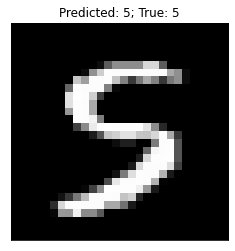

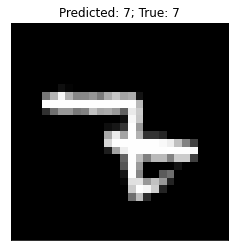

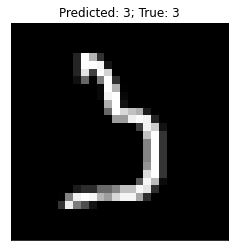

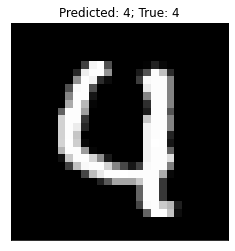

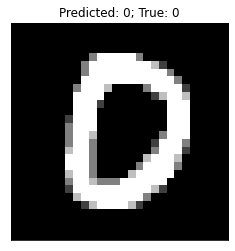

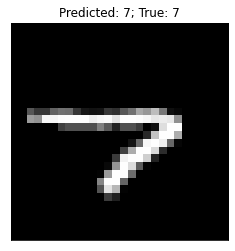

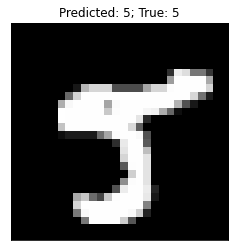

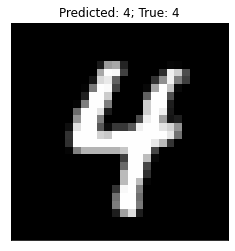

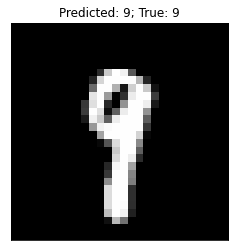

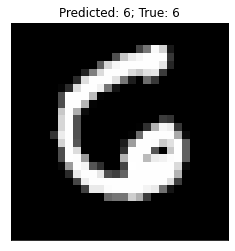

In [ ]:
# get 10 random indices from test data
sample_indices = torch.randint(len(test_data), (10,))
# obtain subset of test data using the generated sample_indices
sample_test_data = Subset(test_data, sample_indices)
# wrap dataloader around sample_test_data
sample_test_dataloader = DataLoader(sample_test_data, batch_size=1, shuffle=False)
# obtain subset of predictions for test data samples
sample_predictions = torch.index_select(predictions, 0, sample_indices)

# enumerate samples for visualization
samples = enumerate(sample_test_dataloader)

# visualize the 10 test data points randomly selected and plot the image with
# the predicted and true labels
for i in range(10):
  batch_idx, (sample_feature, sample_target) = next(samples)
  plt.imshow(sample_feature[0][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {}".format(sample_predictions[i]) + "; True: {}".format(sample_target[0]))
  plt.xticks([])
  plt.yticks([])
  plt.show()

Reload best MLP model

In [ ]:
# create placeholder for the best model to be loaded
best_model = MLP(input_dim, hidden_dim, output_dim)
# create placeholder for the best optimizer to be loaded
best_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# reload best model
model_state_dict = torch.load('model.pth')
best_model.load_state_dict(model_state_dict)

# reload best optimizer
optimizer_state_dict = torch.load('optimizer.pth')
best_optimizer.load_state_dict(optimizer_state_dict)

Test accuracy using the best MLP model

In [ ]:
print(f"Test Accuracy for MLP using the Best Model\n\n")

# calculate test accuracy using the best model and obtain label predictions
predictions = test(test_dataloader, best_model)
# predictions is populated in batches, so we are concatenating
# the results
predictions = torch.stack(predictions)
# flatten stacked results into a 1D array
predictions = predictions.reshape(1, -1).squeeze()

Test Accuracy for MLP using the Best Model


Test Accuracy: 97.8% 



# Convolutional Neural Network: LeNet

Specify hyperparameters

In [ ]:
NUM_EPOCHS = 20 # number of times the network will see the entire training set
TRAIN_BATCH_SIZE = 50 # number of training points in each iteration
TEST_BATCH_SIZE = 1000 # number of test points in each iteration
LEARNING_RATE = 1e-4 # learning rate for weight and bias updates

Create data loaders for the training, validation, and test sets, which wrap iterables over the sets and support automatic batching, sampling, shuffling and multiprocess data loading.

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

LeNet Convolutional Neural Network


 The network consists of 2 convolutional layers with max pooling and using ReLU activation, a fully connected layer mapping the images to a 1024 dimension feature space, and a linear output layer mapping features to classes. The network uses a softmax cross entropy loss function.

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    """
    Define the first convolutional layer
    - It uses a 5x5 kernel and a stride of 1 pixel, and it will pad the edges 
    with zeros so that the resulting image has the same size as the original image
    - The input channels is 1 because the images are black and white and
    the output channels is chosen to be 32 so that the network learns the
    weights for a stack of 32 separate kernels along with 32 bias variables
    - The resulting images are next activated using ReLU
    - Then, they undergo a 2x2 max pooling, which calculates the maximum value
    for patches of a feature map, and halves both dimensions of the image
    - The output of this layer will result in 32 feature images
    """
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=5, 
            stride=1, 
            padding='same'
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2, 
            stride=2
        )
    )
    # initialize weights and biases for the first convolutional layer
    self.conv1.apply(self.init_parameters)
    """
    Define the second convolutional layer
    - It uses a 5x5 kernel and a stride of 1 pixel, and it will pad the edges 
    with zeros so that the resulting image has the same size as the input image
    - The input channels is 1 because the images are black and white and
    the output channels is chosen to be 64 so the network learns the weights
    from the 32 feature images that resulted from the first convolutional layer;
    the input feature images will have 1/4 the number of pixels as the original
    input images due to the 2x2 pooling in the first conv. layer
    - The resulting images are next activated using ReLU
    - Then, they undergo a 2x2 max pooling, which calculates the maximum value
    for patches of a feature map, and halves both dimensions of the image
    - The output of this layer will result in 64 7x7 feature images
    """
    self.conv2 = nn.Sequential(
        nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=5, 
            stride=1, 
            padding='same'
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    # initialize weights and biases for the second convolutional layer
    self.conv2.apply(self.init_parameters)
    """
    Fully connected hidden layer that maps the feature images from the second
    convolutional layer to a 1024 dimensional feature space
    - The results are activated using ReLU
    - Dropout is added after this layer during forward propagation
    """
    self.fc1 = nn.Sequential(
        nn.Linear(64 * 7 * 7, 1024),
        nn.ReLU()
    )
    # initialize weights and biases for the second convolutional layer
    self.fc1.apply(self.init_parameters)
    """
    Linear output layer that maps the results from the hidden layer to outputs
    """
    self.fc2 = nn.Sequential(
        nn.Linear(1024, 10)
    )
    # initialize weights and biases for the output layer
    self.fc2.apply(self.init_parameters)
  
  def init_parameters(self, layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
      # initialize weights for the layers according to a truncated standard normal
      # distribution (mean=0.0, std=0.1); values outside of 2 standard deviations 
      # are resampled until they fall within 2 standard deviations; truncated normal 
      # helps avoid hidden units synchronizing and not learning individually
      nn.init.trunc_normal_(layer.weight, std=0.1)
      # initialize biases for the layers to a constant value of 0.1 to help
      # prevent hidden units from remaining inactive due to ReLU
      nn.init.constant_(layer.bias, 0.1)
  
  def forward(self, x):
    # pass inputs through the first convolutional layer
    x = self.conv1(x)
    # propagate 32 feature images from the first conv. layer through the second 
    # convolutional layer
    x = self.conv2(x)

    # flatten the output of self.conv2 to (TRAIN_BATCH_SIZE, 64 * 7 * 7)
    x = x.view(x.size(0), -1)

    # propagate outputs of the second conv. layer through the hidden layer
    x = self.fc1(x)
    # we add dropout here, which randomly omits certain units in the hidden 
    # layer, to prevent overfitting; default probability=0.5
    x = F.dropout(x)
    # obtain outputs by propagate through the output layer
    outputs = self.fc2(x)
    return outputs

Instantiate CNN class

In [ ]:
model = Net().to(device)

Instantiate loss class

In [ ]:
# computes softmax and cross entropy; PyTorch CrossEntropyLoss() applies
# LogSoftmax() and NLLLoss() (negative log likelihood loss), so raw logits
# are passed to the loss function
loss_fn = nn.CrossEntropyLoss()

Instantiate optimizer class

We use an AdamOptimizer here

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Train the CNN model

We can use the same train, validate, and test methods from earlier

In [ ]:
print(f"Training CNN with Softmax Cross-Entropy Loss\n\n")
# variable to track validation loss
min_val_loss = np.Inf
# train the model for the set number of epochs
for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, CNN=True)
    # determine validation loss for the current epoch
    val_loss = validate(validation_dataloader, model, loss_fn, CNN=True)
    # update minimum validation loss and save the best model
    if val_loss < min_val_loss:
      print('Validation loss decreased ({:.6f} --> {:.6f})\nSaving model ... \n\n'.format(
        min_val_loss,
        val_loss))
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')
print("Done!")

Training CNN with Softmax Cross-Entropy Loss


Epoch 1
-------------------------------
loss: 16.089109  [    0/55000]
loss: 1.839965  [ 5000/55000]
loss: 0.470557  [10000/55000]
loss: 1.050166  [15000/55000]
loss: 0.560419  [20000/55000]
loss: 0.486345  [25000/55000]
loss: 0.157715  [30000/55000]
loss: 0.304099  [35000/55000]
loss: 0.221859  [40000/55000]
loss: 0.252281  [45000/55000]
loss: 0.169841  [50000/55000]
Validation Error: 
 Accuracy: 93.2%, Validation loss: 1.561228 

Validation loss decreased (inf --> 1.561228)
Saving model ... 


Epoch 2
-------------------------------
loss: 0.159598  [    0/55000]
loss: 0.237677  [ 5000/55000]
loss: 0.071849  [10000/55000]
loss: 0.276652  [15000/55000]
loss: 0.244723  [20000/55000]
loss: 0.244877  [25000/55000]
loss: 0.076516  [30000/55000]
loss: 0.162202  [35000/55000]
loss: 0.265329  [40000/55000]
loss: 0.136847  [45000/55000]
loss: 0.129802  [50000/55000]
Validation Error: 
 Accuracy: 95.7%, Validation loss: 1.524095 

Validation loss d

Calculate test accuracy for CNN

In [ ]:
print(f"Test Accuracy for CNN\n\n")

# calculate test accuracy and obtain label predictions
predictions = test(test_dataloader, model, CNN=True)
# predictions is populated in batches, so we are concatenating
# the results
predictions = torch.stack(predictions)
# flatten stacked results into a 1D array
predictions = predictions.reshape(1, -1).squeeze()

Test Accuracy for CNN


Test Accuracy: 98.9% 



Plot of 10 random digits from test set

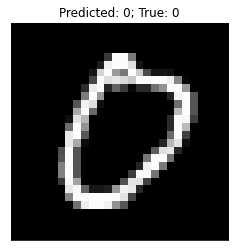

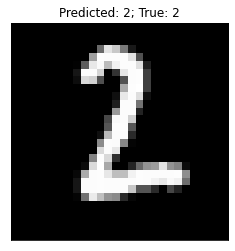

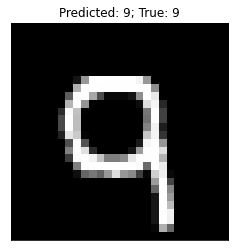

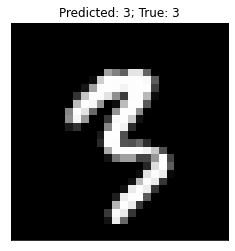

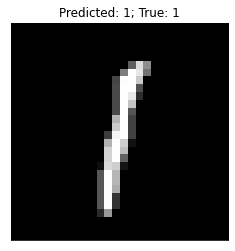

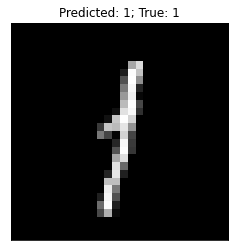

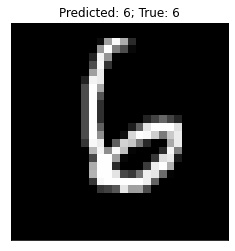

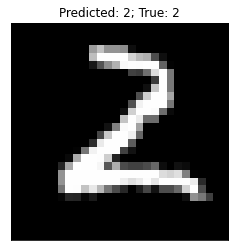

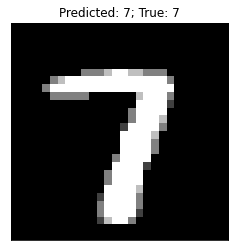

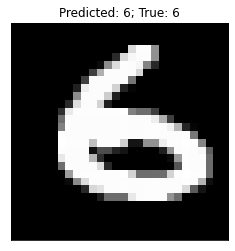

In [ ]:
# get 10 random indices for test data
sample_indices = torch.randint(len(test_data), (10,))
# obtain subset of test data using the generated sample_indices
sample_test_data = Subset(test_data, sample_indices)
# wrap dataloader around sample_test_data
sample_test_dataloader = DataLoader(sample_test_data, batch_size=1, shuffle=False)
# obtain subset of predictions for test data samples
sample_predictions = torch.index_select(predictions, 0, sample_indices)

# enumerate samples for visualization
samples = enumerate(sample_test_dataloader)

# visualize the 10 test data points randomly selected and plot the image with
# the predicted and true labels
for i in range(10):
  batch_idx, (sample_feature, sample_target) = next(samples)
  plt.imshow(sample_feature[0][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {}".format(sample_predictions[i]) + "; True: {}".format(sample_target[0]))
  plt.xticks([])
  plt.yticks([])
  plt.show()

Reload best CNN model

In [ ]:
# create placeholder for the best model to be loaded
best_model = Net()
# create placeholder for the best optimizer to be loaded
best_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# reload best model
model_state_dict = torch.load('model.pth')
best_model.load_state_dict(model_state_dict)

# reload best optimizer
optimizer_state_dict = torch.load('optimizer.pth')
best_optimizer.load_state_dict(optimizer_state_dict)

Test accuracy using best CNN model

In [ ]:
print(f"Test Accuracy for CNN using the Best Model\n\n")

# calculate test accuracy using the best model and obtain label predictions
predictions = test(test_dataloader, best_model, CNN=True)
# predictions is populated in batches, so we are concatenating
# the results
predictions = torch.stack(predictions)
# flatten stacked results into a 1D array
predictions = predictions.reshape(1, -1).squeeze()

Test Accuracy for CNN using the Best Model


Test Accuracy: 98.9% 



Final step through some test examples to evaluate CNN performance

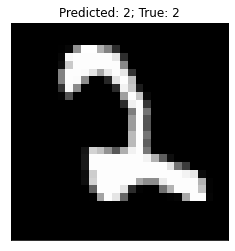

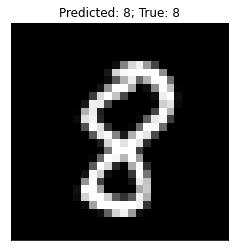

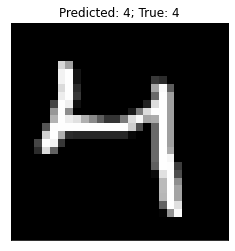

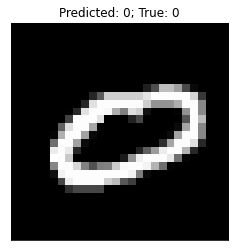

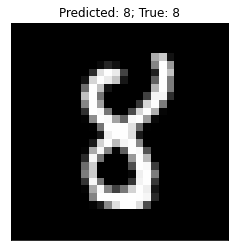

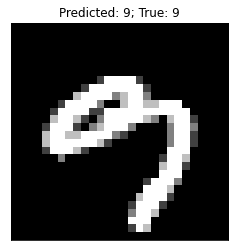

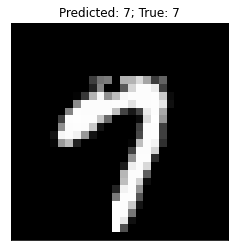

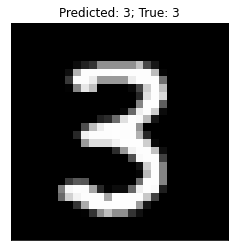

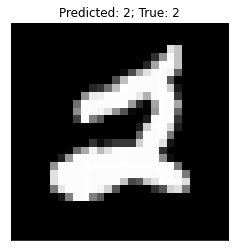

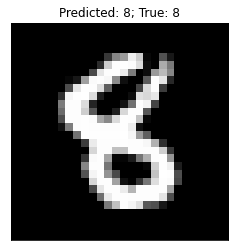

In [ ]:
# get 10 random indices for test data
sample_indices = torch.randint(len(test_data), (10,))
# obtain subset of test data using the generated sample_indices
sample_test_data = Subset(test_data, sample_indices)
# wrap dataloader around sample_test_data
sample_test_dataloader = DataLoader(sample_test_data, batch_size=1, shuffle=False)
# obtain subset of predictions for test data samples
sample_predictions = torch.index_select(predictions, 0, sample_indices)

# enumerate samples for visualization
samples = enumerate(sample_test_dataloader)

# visualize the 10 test data points randomly selected and plot the image with
# the predicted and true labels
for i in range(10):
  batch_idx, (sample_feature, sample_target) = next(samples)
  plt.imshow(sample_feature[0][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {}".format(sample_predictions[i]) + "; True: {}".format(sample_target[0]))
  plt.xticks([])
  plt.yticks([])
  plt.show()